In [124]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns

from biobank_olink.constants import PROJECT_ROOT

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()]
results = pd.DataFrame(chain.from_iterable(results))
results.loc[results.model.isna(), "model"] = "xgb"
results["target"] = results.target.str.upper()

targets = ["SBP", "DBP", "PP"]
panels = ["all", "inflammation"]

results_base = results.loc[
    results.interactions.isin((0, np.nan, None)) & results.n_best_feats.isin((0, np.nan, None))]

In [107]:
results_xgb = results_base.loc[results_base.model == "xgb"]
results_xgb.loc[:, "feat_importance"] = results_xgb.feat_importance.apply(
    lambda x: x[0] if isinstance(x, list) else x)
agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results_xgb.groupby(["model", "panel", "target", "nan_th"]).agg(**agg_values,
                                                                count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel        target nan_th                                    
xgb   all          DBP    0.0           0.783071            507.0   
                          0.3           0.794324            207.0   
                          0.6           0.781253            207.0   
                   PP     0.0           0.718911            507.0   
                          0.3           0.715093            206.8   
                          0.6           0.713577            207.0   
                   SBP    0.0           0.799976            507.0   
                          0.3           0.803424            207.0   
                          0.6           0.796614            223.0   
      inflammation DBP    0.3           0.711251            214.8   
                   PP     0.3           0.646783            207.0   
                   SBP    0.3           0.721584            206.8   

                                  mean_best_trial_no  mean_n_estimators  count  
model panel        target nan_th                                                
xgb   all          DBP    0.0                  388.6             2535.8      5  
                          0.3                  145.2             2537.2      5  
                          0.6                  139.2             1915.6      5  
                   PP     0.0                  366.4             2551.6      5  
                          0.3                  163.8             2235.0      5  
                          0.6                  182.2             2254.2      5  
                   SBP    0.0                  336.6             2576.0      5  
                          0.3                  178.0             2266.6      5  
                          0.6                  186.0             2261.0      5  
      inflammation DBP    0.3                  180.6             2306.8      5  
                   PP     0.3                  188.6             2658.4      5  
                   SBP    0.3                  172.4             2114.8      5

In [108]:
res_xgb_gb = results_xgb.groupby(["model", "panel", "target"]).agg(**agg_values,
                                                                   count=("model", 'size'))
res_xgb_gb["mean_auc_score"].unstack("target").reorder_levels([1, 0]).sort_index().loc[:, targets]

,target,SBP,DBP,PP
panel,model,,,
all,xgb,0.800005,0.786216,0.715861
inflammation,xgb,0.721584,0.711251,0.646783


/home/prenc/.miniconda3/envs/biobank_olink/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


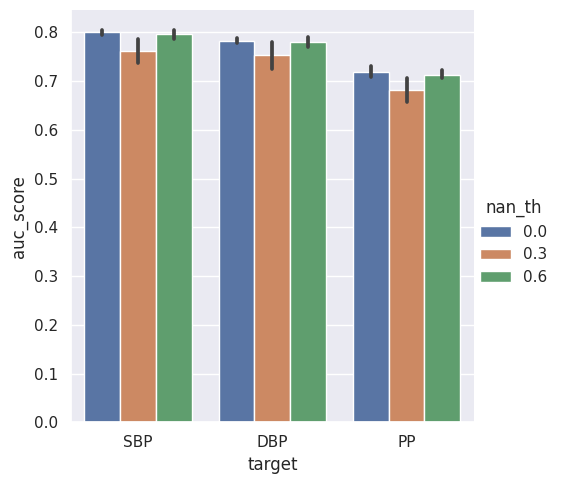

In [109]:
sns.catplot(data=results_xgb, x="target", y="auc_score",
            order=targets, hue="nan_th", kind="bar", col_order=panels)

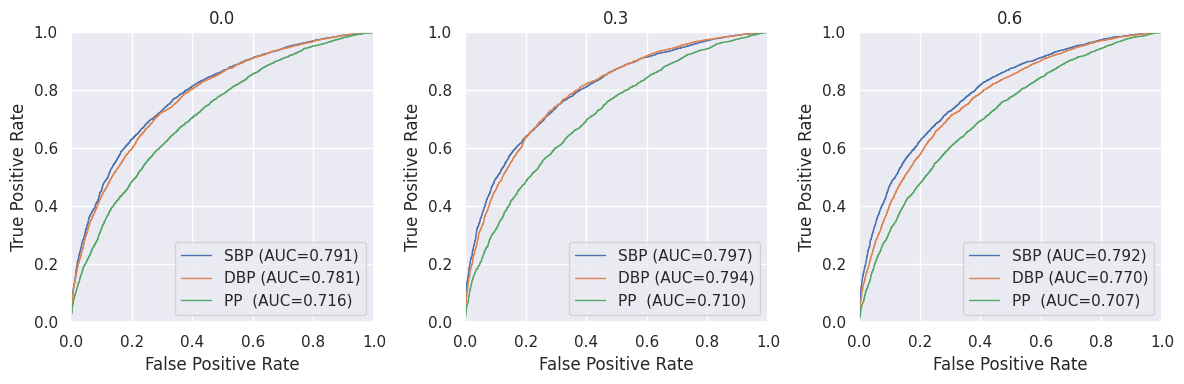

In [110]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_auc_curve_by_panels(results, res_feat):
    plt.figure(figsize=(12, 4))
    for i, feat in enumerate(results[res_feat].unique(), 1):
        plt.subplot(1, 3, i)
        plt.xlim([0, 1.0])
        plt.ylim([0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(str(feat).title())

        for target in targets:
            single_case = results.loc[(results.target == target) & (results[res_feat] == feat)]
            if single_case.empty:
                continue
            y_test, y_prob = single_case["y_test"].values, single_case["y_proba"].values
            y_test, y_prob = np.concatenate(y_test), np.concatenate(y_prob)

            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label=f"{target:<3} (AUC={auc_score:.3f})")

        plt.legend(loc='lower right')

    plt.tight_layout()


plot_auc_curve_by_panels(results_xgb.loc[results_xgb.panel == "all"], "nan_th")
plt.show()

In [111]:
results_xgb = results_xgb.loc[results_xgb.nan_th == 0].copy()

## Feature importances

In [112]:
feat_imps = results_xgb.loc[
    (results_xgb.target == "SBP") & (results_xgb.panel == "all")].shap_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps.rank(ascending=False).astype(int)

,0,1,2,3,4
REN,1,1,1,1,1
PTPRB,2,2,2,2,3
ACTA2,3,3,3,3,2
CHGB,4,5,4,11,4
NADK,5,8,10,4,9
...,...,...,...,...,...
PNMA1,2681,2267,1693,2470,1856
NT5C,2681,2643,2692,2368,2370
SERPINF2,2681,1480,2048,2483,2572
CD84,2681,2643,2480,2676,2013


In [113]:
from biobank_olink.dataset import get_olink_panel_mapping, compute_correlations_in_df

ol_df_corr = compute_correlations_in_df(None, shape=(53029, 2923))
corr_th = 0.8
mask = np.triu(np.ones(ol_df_corr.shape), k=1).astype(bool)
high_corr = ol_df_corr.where(mask)
correlated_cols = {column: dict(zip(high_corr.columns[high_corr[column] > corr_th].tolist(),
                                    high_corr[column][high_corr[column] > corr_th].tolist()))
                   for column in high_corr.columns}

assays_mapping = get_olink_panel_mapping()


def olink_to_panels(olink):
    return [
        panel
        for panel, olinks in assays_mapping.items()
        if olink in olinks
    ]


def get_feat_imps(res, panel):
    feat_imps = (
        res.loc[(res.panel == panel)]
        .groupby("target").shap_importance
        .apply(lambda x: pd.DataFrame(x.values.tolist()).mean().sort_values(ascending=False))
        .unstack("target")
    )
    present_targets = [col for col in targets if col in feat_imps.columns]
    feat_imps = feat_imps[present_targets]
    feat_ranks = feat_imps.rank(ascending=False)
    feat_ranks.columns = [f"{col}_rank" for col in feat_ranks.columns]
    feat_imps = pd.concat([feat_imps, feat_ranks], axis=1)
    feat_imps = feat_imps[[f"{col}{suffix}" for col in present_targets for suffix in ["", "_rank"]]]
    return feat_imps


feat_imps = get_feat_imps(results_xgb, "all")
feat_imps["panel"] = feat_imps.index.map(olink_to_panels)
feat_imps[f"correlates_with (corr>{corr_th})"] = feat_imps.index.map(correlated_cols)
feat_imps.sort_values("SBP", ascending=False)

[Memory]58500.1s, 975.0min: Loading compute_correlations_in_df...


,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank,panel,correlates_with (corr>0.8)
REN,1175.159668,1.0,1211.921655,1.0,NaN,NaN,[cardiometabolic],{}
PTPRB,464.535553,2.0,329.180536,2.0,NaN,NaN,[cardiometabolic],{}
ACTA2,419.937628,3.0,286.710239,3.0,NaN,NaN,[cardiometabolic],{}
CHGB,249.975992,4.0,129.221701,28.0,NaN,NaN,[neurology],{}
AMIGO2,241.560257,5.0,92.987297,47.0,NaN,NaN,[oncology],{}
...,...,...,...,...,...,...,...,...
RGS10,0.267641,2712.0,0.267135,2707.0,NaN,NaN,[neurology],"{'ACOT13': 0.8166712673319036, 'AKT2': 0.86034..."
NEK7,0.178262,2713.0,1.648540,2573.0,NaN,NaN,[oncology],{}
STXBP1,0.159856,2714.0,0.192199,2712.0,NaN,NaN,[neurology],"{'ACOT13': 0.8236027702308701, 'AK2': 0.837435..."
GLIPR1,0.000000,2715.0,0.000000,2715.0,NaN,NaN,[oncology],{}


## export all feature importances

In [126]:
from biobank_olink.constants import PROJECT_DATA

feat_importances_dir = PROJECT_DATA / "feat_importances"
feat_importances_dir.mkdir(exist_ok=True)

for study_name in results_base.study_name.unique():
    series = []
    study_res = results.loc[results.study_name == study_name]

    feat_imps = study_res.feat_importance
    series.append(feat_imps.apply(pd.Series).mean())
    series.append(feat_imps.apply(pd.Series).rank(ascending=False, axis=1).mean())

    shap_imps = study_res.shap_importance
    series.append(shap_imps.apply(pd.Series).mean())
    series.append(shap_imps.apply(pd.Series).rank(ascending=False, axis=1).mean())

    importance = pd.concat(series, axis=1)
    importance.columns = ["feat_importance", "feat_importance_rank",
                          "shap_importance", "shap_importance_rank"]
    importance["panel"] = importance.index.map(olink_to_panels)
    importance[f"correlates_with (corr>{corr_th})"] = importance.index.map(correlated_cols)
    importance.to_csv(feat_importances_dir / f"{study_name}.csv")

## LogisticRegressions - interactions

In [60]:
res_inter = results.loc[results.interactions > 0]
res_inter.groupby(["model", "panel", "target", "interactions"]).agg(**agg_values,
                                                                    count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel target interactions                                    
lr    all   DBP    10.0                0.806233            221.4   
            PP     10.0                0.736474            206.6   
            SBP    10.0                0.818562            223.0   

                                 mean_best_trial_no  mean_n_estimators  count  
model panel target interactions                                                
lr    all   DBP    10.0                       192.4                NaN      5  
            PP     10.0                       164.8                NaN      5  
            SBP    10.0                       176.6                NaN      5

In [63]:
get_feat_imps(res_inter, "all").sort_values("SBP", ascending=False)

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.027764,1.0,0.029997,1.0,0.012055,1.0
CHGB,0.009412,2.0,0.006543,5.0,0.008458,2.0
ACTA2,0.008610,3.0,0.006961,4.0,0.005572,4.0
VWC2,0.008083,4.0,0.006155,9.0,0.004222,16.0
CRIP2,0.007592,5.0,0.008815,2.0,0.004981,10.0
...,...,...,...,...,...,...
SPINK6*ADGRG2,NaN,NaN,NaN,NaN,0.000365,749.0
SPINK6*AMIGO2,NaN,NaN,NaN,NaN,0.000991,315.0
SPINK6*FCGR2B,NaN,NaN,NaN,NaN,0.000387,725.0
SPINK6*LSP1,NaN,NaN,NaN,NaN,0.000503,611.0


## N best features

In [373]:
res_n_best = results.loc[results.n_best_feats.notna()]
res_n_best.groupby(["model", "panel", "target", "n_best_feats"]).agg(**agg_values,
                                                                     count=("model", 'size'))

mean_auc_score  mean_num_trials  \
model panel target n_best_feats                                    
lr    all   DBP    200.0               0.780377            227.2   
                   500.0               0.791994            207.2   
            PP     200.0               0.709120            226.2   
                   500.0               0.724223            205.8   
            SBP    200.0               0.776875            226.8   
                   500.0               0.796892            206.0   

                                 mean_best_trial_no  mean_reg_alpha  count  
model panel target n_best_feats                                             
lr    all   DBP    200.0                       85.6             NaN      5  
                   500.0                       74.6             NaN      5  
            PP     200.0                       56.2             NaN      5  
                   500.0                       46.6             NaN      5  
            SBP    200.0                       63.6             NaN      5  
                   500.0                       96.4             NaN      5

In [377]:
feat_imps_n_best200 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 200],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best200

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.053249,1.0,0.055465,1.0,0.034907,1.0
NTRK3,0.016559,2.0,0.016539,3.0,0.008334,28.0
SPINK6,0.016470,3.0,0.014761,7.0,0.014470,8.0
LDLR,0.015345,4.0,0.007389,42.0,NaN,NaN
CRIP2,0.014823,5.0,0.017034,2.0,0.017069,5.0
...,...,...,...,...,...,...
TNFRSF9,NaN,NaN,NaN,NaN,0.007023,40.0
TNFSF10,NaN,NaN,NaN,NaN,0.001617,166.0
TRAF2,NaN,NaN,NaN,NaN,0.004408,88.0
TSHB,NaN,NaN,0.009303,24.0,NaN,NaN


In [379]:
feat_imps_n_best500 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 500],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best500

,SBP,SBP_rank,DBP,DBP_rank,PP,PP_rank
REN,0.031186,1.0,0.033767,1.0,0.018394,1.0
CHGB,0.011459,2.0,0.008744,5.0,0.013755,2.0
ACTA2,0.010796,3.0,0.008771,4.0,0.007913,5.0
CRIP2,0.008242,4.0,0.010294,2.0,0.007889,6.0
EFNA1,0.008216,5.0,NaN,NaN,0.010229,3.0
...,...,...,...,...,...,...
UXS1,NaN,NaN,NaN,NaN,0.001989,188.0
VSIG4,NaN,NaN,NaN,NaN,0.001965,190.0
WAS,NaN,NaN,0.000904,369.0,NaN,NaN
WFDC2,NaN,NaN,NaN,NaN,0.003842,51.0


In [385]:
n = 10
len(feat_imps_n_best500.index[:n].intersection(feat_imps_n_best200.index[:n])) / n

0.6